## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

from utils.layer_wrappers import ModuleWrapperLinear, ModuleWrapperConv1d
from layers.BayesianConv1d import BayesianConv1d
from layers.BayesianLinear import BayesianLinear

## Parameters

In [2]:
BATCH_SIZE = 64
NUM_CLASSES = 3
LR = 1e-3
KL_WEIGHT = 1e-8
EPOCHS = 15
T = 15

PRIORS = {
    'prior_mu': 0,
    'prior_sigma': 0.1,
    'posterior_mu_initial': (0.0, 0.1),
    'posterior_rho_initial': (-3.0, 0.1)
}  

SITE = 'B'
YEAR = 2020

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using Device: {DEVICE}')

Using Device: cuda


## Loading Files

In [3]:
X = np.load(f'/kaggle/input/data-usa/Site_{SITE}/x-{YEAR}.npy')
y = np.load(f'/kaggle/input/data-usa/Site_{SITE}/y-{YEAR}.npy')

print(f'Loaded Data of Site {SITE} - {YEAR}')
print(X.shape, y.shape)

Loaded Data of Site B - 2020
(1943716, 28, 6) (1943716,)


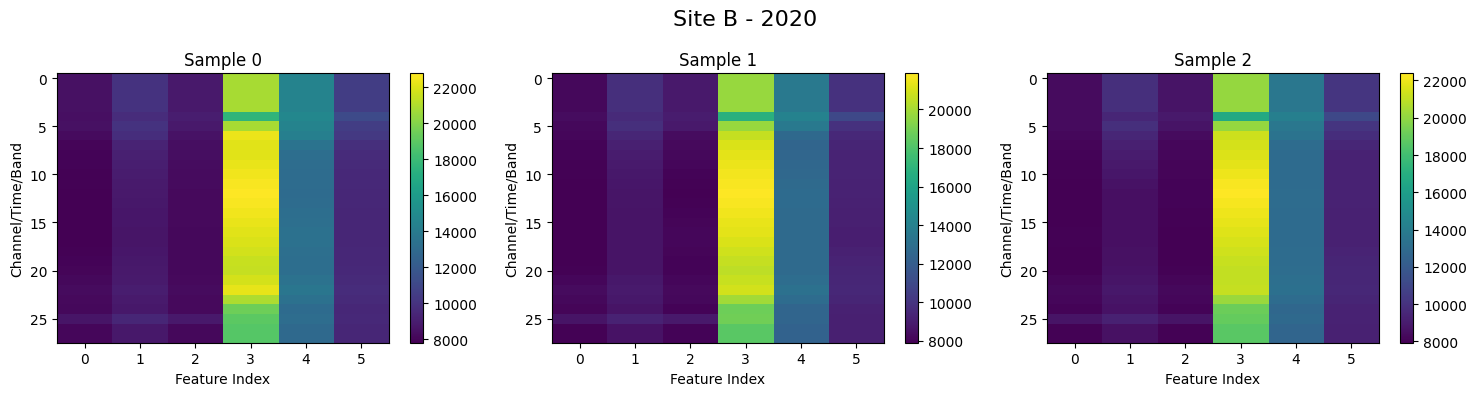

In [4]:
# Ploting the preprocessed feature maps
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i in range(3):
    im = axes[i].imshow(X[i], aspect='auto', cmap='viridis')
    axes[i].set_title(f"Sample {i}")
    axes[i].set_xlabel("Feature Index")
    axes[i].set_ylabel("Channel/Time/Band")
    fig.colorbar(im, ax=axes[i], orientation='vertical')

fig.suptitle(f"Site {SITE} - {YEAR}", fontsize=16)
plt.tight_layout()
plt.show()

In [5]:
print(f'\n\n======= For Site {SITE} - {YEAR} =======')
feature_means = X.mean(axis=(0, 1))  # average over samples and features
feature_stds = X.std(axis=(0, 1))

for i, (m, s) in enumerate(zip(feature_means, feature_stds)):
    print(f"Feature {i}: Mean = {m:.4f}, Std = {s:.4f}")

# Compute overall mean and std
mean = X.mean()
std = X.std()

print(f"\nGlobal Mean: {mean:.4f}")
print(f"Global Std Dev: {std:.4f}")



======= For Site B - 2020 =======
Feature 0: Mean = 9293.7332, Std = 1062.0828
Feature 1: Mean = 10402.3986, Std = 1328.2403
Feature 2: Mean = 10579.1004, Std = 1999.1082
Feature 3: Mean = 18968.7555, Std = 4274.7314
Feature 4: Mean = 16319.4431, Std = 3346.2848
Feature 5: Mean = 13205.7260, Std = 3494.6972

Global Mean: 13128.1928
Global Std Dev: 4500.1056


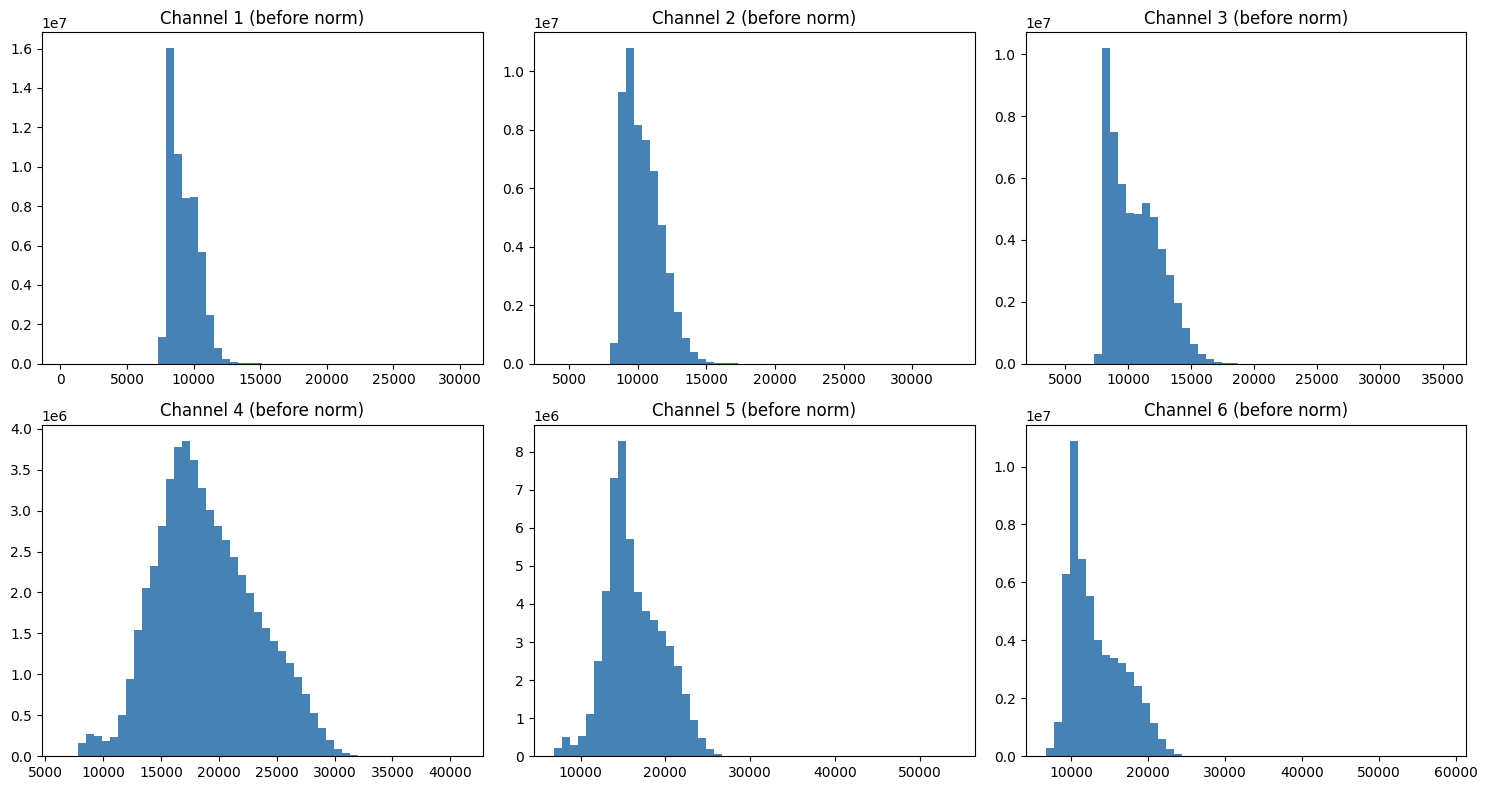

In [6]:
X_hist = X.reshape(-1, 6)  # shape: (N*T, 6)

# Before normalization
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs = axs.ravel()

for i in range(6):
    axs[i].hist(X_hist[:, i], bins=50, color='steelblue', alpha=1)
    axs[i].set_title(f'Channel {i+1} (before norm)')
plt.tight_layout()
plt.show()

## Preprocessing the Input

In [7]:
# Standardizing the input features across all timesteps and samples using Z-scores
# Compute per-feature mean and std across all samples and timesteps
feature_means = X.mean(axis=(0, 1))  # Shape: (6,)
feature_stds = X.std(axis=(0, 1))    # Shape: (6,)

# Reshape for broadcasting
feature_means = feature_means.reshape(1, 1, -1)  # Shape: (1, 1, 6)
feature_stds = feature_stds.reshape(1, 1, -1)    # Shape: (1, 1, 6)

# Standardize
X = ((X - feature_means) / feature_stds).astype(np.float32)

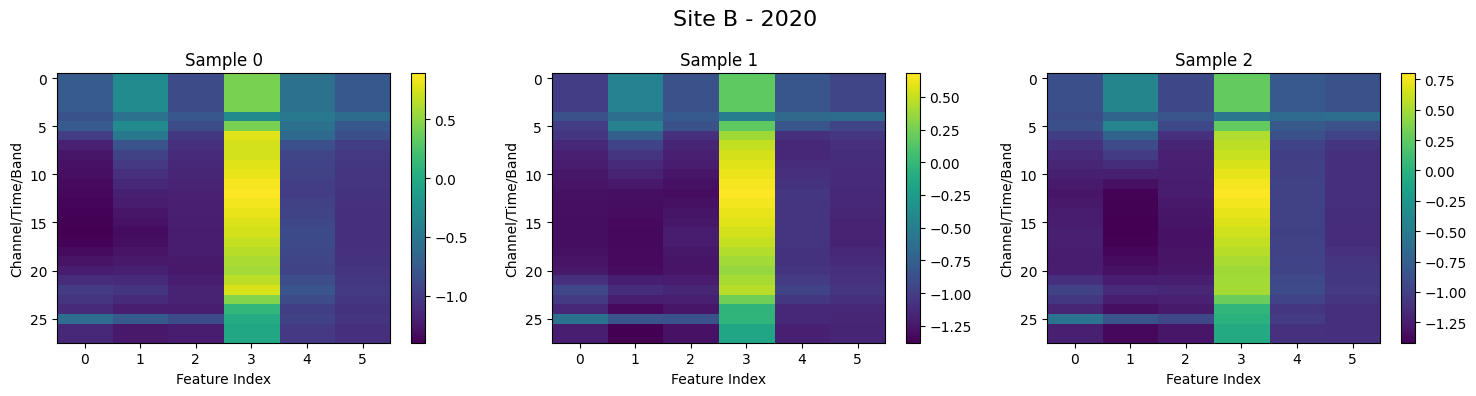

In [8]:
# Ploting the preprocessed feature maps
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i in range(3):
    im = axes[i].imshow(X[i], aspect='auto', cmap='viridis')
    axes[i].set_title(f"Sample {i}")
    axes[i].set_xlabel("Feature Index")
    axes[i].set_ylabel("Channel/Time/Band")
    fig.colorbar(im, ax=axes[i], orientation='vertical')

fig.suptitle(f"Site {SITE} - {YEAR}", fontsize=16)
plt.tight_layout()
plt.show()

In [9]:
print(f'\n\n======= For Site {SITE} - {YEAR} =======')
feature_means = X.mean(axis=(0, 1))  # average over samples and features
feature_stds = X.std(axis=(0, 1))

for i, (m, s) in enumerate(zip(feature_means, feature_stds)):
    print(f"Feature {i}: Mean = {m:.4f}, Std = {s:.4f}")

# Compute overall mean and std
mean = X.mean()
std = X.std()

print(f"\nGlobal Mean: {mean:.4f}")
print(f"Global Std Dev: {std:.4f}")



======= For Site B - 2020 =======
Feature 0: Mean = -0.0000, Std = 0.8846
Feature 1: Mean = -0.0000, Std = 0.8950
Feature 2: Mean = 0.0000, Std = 0.8862
Feature 3: Mean = 0.0001, Std = 0.9253
Feature 4: Mean = 0.0000, Std = 0.9230
Feature 5: Mean = 0.0000, Std = 0.8994

Global Mean: -0.0000
Global Std Dev: 1.0000


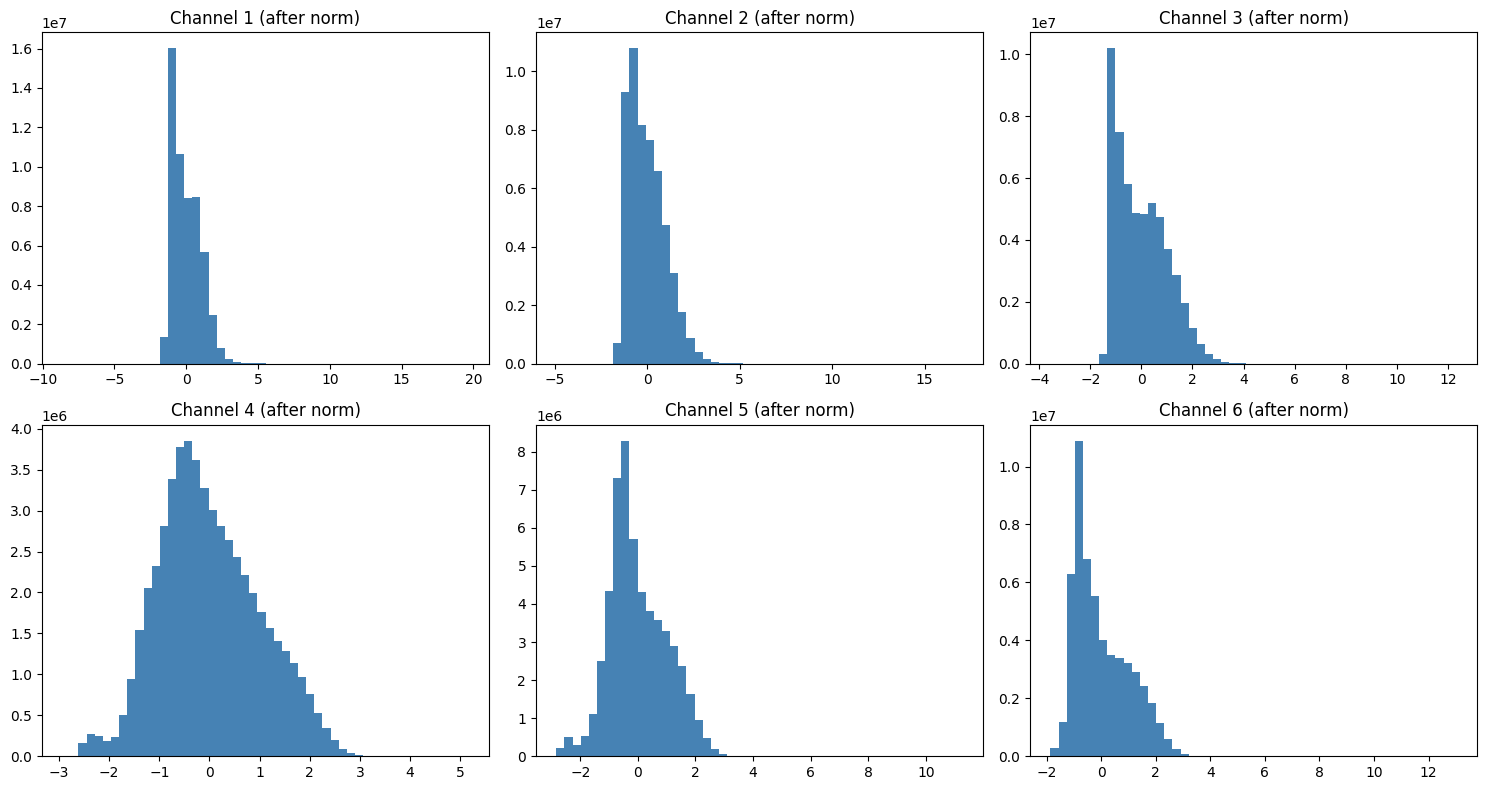

In [10]:
X_hist = X.reshape(-1, 6)  # shape: (N*T, 6)

# After normalization
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs = axs.ravel()

for i in range(6):
    axs[i].hist(X_hist[:, i], bins=50, color='steelblue', alpha=1)
    axs[i].set_title(f'Channel {i+1} (after norm)')
plt.tight_layout()
plt.show()

## Label Distribution



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         871034    44.81%
1         260775    13.42%
2         811907    41.77%

Total samples: 1943716


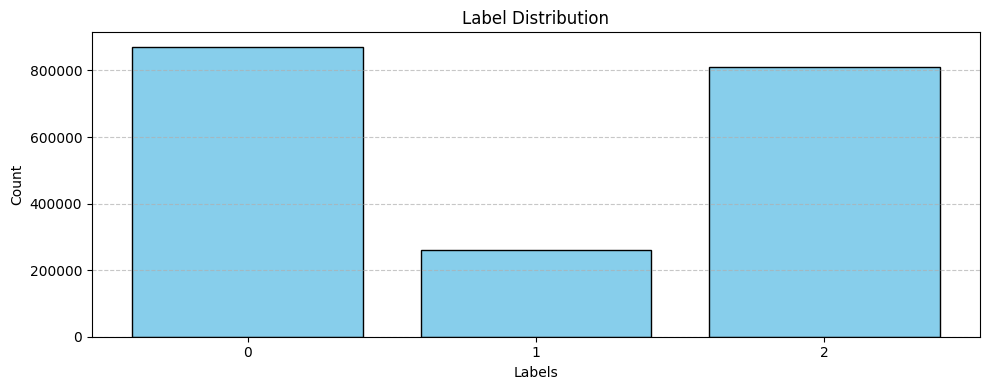

In [11]:
# Checking the label distribution of training data
print('\n\n====== Label Distribution ======')
unique_labels, counts = np.unique(y, return_counts=True)
total = counts.sum()
print(f"{'Label':<10}{'Count':<10}{'Percentage':<10}")
print("-" * 30)
for label, count in zip(unique_labels, counts):
    percentage = (count / total) * 100
    print(f"{label:<10}{count:<10}{percentage:<.2f}%")

print(f"\nTotal samples: {total}")

# Plot histogram for training data
unique_labels, counts = np.unique(y, return_counts=True)
plt.figure(figsize=(10, 4))
plt.bar(unique_labels.astype(str), counts, color='skyblue', edgecolor='black')
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title(f"Label Distribution")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Data Splits

In [12]:
# Taking only 25% percent of the data
X_subset, X_test, y_subset, y_test = train_test_split(X, y, test_size=0.75, stratify=y, random_state=42)
print('Subset Data:', X_subset.shape, y_subset.shape)
print('Test Data:', X_test.shape, y_test.shape)

Subset Data: (485929, 28, 6) (485929,)
Test Data: (1457787, 28, 6) (1457787,)


In [13]:
# Train/Val Split
X_train, X_val, y_train, y_val = train_test_split(X_subset, y_subset, test_size=0.2, stratify=y_subset, random_state=42)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(388743, 28, 6) (388743,)
(97186, 28, 6) (97186,)


In [14]:
# Checking if the training data is normalized correctly
print(f'\n\n======= Training data =======')
feature_means = X_train.mean(axis=(0, 1))  # average over samples and features
feature_stds = X_train.std(axis=(0, 1))

for i, (m, s) in enumerate(zip(feature_means, feature_stds)):
    print(f"Feature {i}: Mean = {m:.4f}, Std = {s:.4f}")

# Compute overall mean and std
mean = X_train.mean()
std = X_train.std()

print(f"\nGlobal Mean: {mean:.4f}")
print(f"Global Std Dev: {std:.4f}")



======= Training data =======
Feature 0: Mean = 0.0013, Std = 0.9957
Feature 1: Mean = 0.0013, Std = 0.9936
Feature 2: Mean = 0.0009, Std = 0.9921
Feature 3: Mean = 0.0006, Std = 0.9914
Feature 4: Mean = 0.0005, Std = 0.9904
Feature 5: Mean = 0.0004, Std = 0.9946

Global Mean: 0.0008
Global Std Dev: 1.0006




====== Label Distribution - Training data ======
Label     Count     Percentage
------------------------------
0         174206    44.81%
1         52155     13.42%
2         162382    41.77%

Total samples: 388743


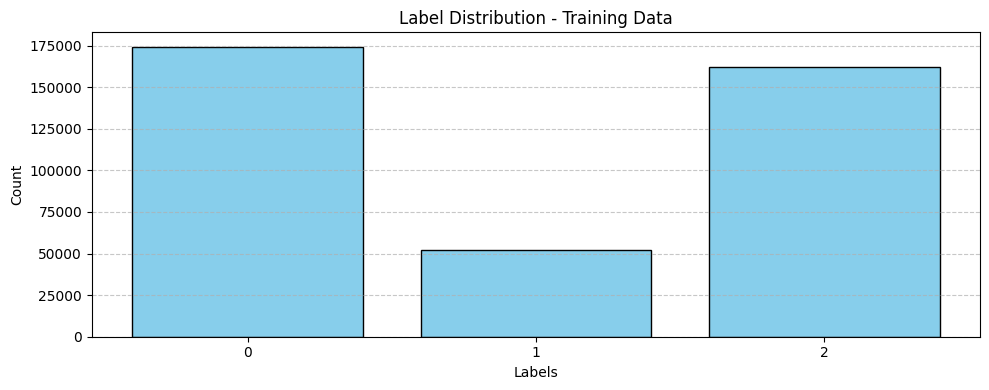

In [15]:
# Checking the label distribution of training data
print('\n\n====== Label Distribution - Training data ======')
unique_labels, counts = np.unique(y_train, return_counts=True)
total = counts.sum()
print(f"{'Label':<10}{'Count':<10}{'Percentage':<10}")
print("-" * 30)
for label, count in zip(unique_labels, counts):
    percentage = (count / total) * 100
    print(f"{label:<10}{count:<10}{percentage:<.2f}%")

print(f"\nTotal samples: {total}")

# Plot histogram for training data
unique_labels, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(10, 4))
plt.bar(unique_labels.astype(str), counts, color='skyblue', edgecolor='black')
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title(f"Label Distribution - Training Data")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Dataset and DataLoader

In [16]:
class Conv1dDataset(Dataset):
    def __init__(self, X, y):
        """
        X expected shape: (N, T, F)  -> convert to (N, C, L) with C=F, L=T
        Transpose to (N, F, T)
        """
        self.X = torch.tensor(X.transpose(0, 2, 1), dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [17]:
train_dataset = Conv1dDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = Conv1dDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset = Conv1dDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Model

In [18]:
# Blocks (Conv + FC) 
# ----------------------------
class Conv1d_BayesBlock(ModuleWrapperConv1d):
    """BBBConv1d + BN + ReLU inside a Conv1d wrapper"""
    def __init__(self, in_ch, out_ch, kernel_size, priors, device='cpu', padding=0):
        super().__init__()
        self.conv = BayesianConv1d(in_ch, out_ch, kernel_size, padding=padding, priors=priors, device=device)
        self.bn = nn.BatchNorm1d(out_ch)
        self.act = nn.ReLU()

class FCBayesBlock(ModuleWrapperLinear):
    """BBBLinear (optionally add activation if you want)"""
    def __init__(self, in_f, out_f, priors, device='cpu'):
        super().__init__()
        self.fc = BayesianLinear(in_f, out_f, priors=priors, device=device)

In [19]:
########################################
# Bayesian CNN + FC Model
########################################
class BayesianCNN_FC(nn.Module):
    def __init__(self, in_channels=6,  num_classes=3, priors=None, device='cpu'):
        super().__init__()
        self.device = device
        self.conv1 = Conv1d_BayesBlock(in_channels, 64, 5, priors, device=device, padding=2)
        self.conv2 = Conv1d_BayesBlock(64, 128, 5, priors, device=device, padding=2)
        self.conv3 = Conv1d_BayesBlock(128, 256, 5, priors, device=device, padding=2)
        self.conv4 = Conv1d_BayesBlock(256, 512, 5, priors, device=device, padding=2)
        self.conv5 = Conv1d_BayesBlock(512, 1024, 5, priors, device=device, padding=2)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = FCBayesBlock(1024, num_classes, priors, device=device)

    def forward(self, x, sample=True, n_samples=1):
        # x: (batch, channels, length)  OR  (n_samples, batch, channels, length)
        kl_total = torch.tensor(0.0, device=x.device)

        x, kl = self.conv1(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv2(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv3(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv4(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv5(x, sample=sample, n_samples=n_samples); kl_total += kl

        # global pool (handle sample dim)
        if x.dim() == 4:  # (T, B, C, L)
            T_, B_, C_, L_ = x.shape
            x = x.reshape(T_ * B_, C_, L_)
            x = self.global_pool(x)             # (T*B, C, 1)
            x = x.squeeze(-1)                   # (T*B, C)
            x = x.reshape(T_, B_, C_)           # (T, B, C)
        elif x.dim() == 3:  # (B, C, L)
            x = self.global_pool(x)             # (B, C, 1)
            x = x.squeeze(-1)                   # (B, C)
        else:
            raise ValueError(f"Unexpected shape: {x.shape}")

        x, kl_fc = self.fc(x, sample=sample, n_samples=n_samples)
        kl_total += kl_fc

        return x, kl_total

In [20]:
########################################
# Model Initialization
########################################
model = BayesianCNN_FC(in_channels=6, num_classes=3, priors=PRIORS, device=DEVICE).to(DEVICE)
model = torch.compile(model, backend='eager')
print(model)

OptimizedModule(
  (_orig_mod): BayesianCNN_FC(
    (conv1): Conv1d_BayesBlock(
      (conv): BayesianConv1d()
      (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
    (conv2): Conv1d_BayesBlock(
      (conv): BayesianConv1d()
      (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
    (conv3): Conv1d_BayesBlock(
      (conv): BayesianConv1d()
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
    (conv4): Conv1d_BayesBlock(
      (conv): BayesianConv1d()
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
    (conv5): Conv1d_BayesBlock(
      (conv): BayesianConv1d()
      (bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
    (global_pool): AdaptiveAvgPool1d(outpu

In [21]:
# Loading model trained on SiteA-2019
checkpoint = torch.load("/kaggle/input/bcnn/pytorch/default/1/BCNN.pth", map_location=torch.device("cpu"))
model.load_state_dict(checkpoint)

<All keys matched successfully>

## Evaluation Function

In [22]:
def compute_accuracy_per_sample_mean(outputs, labels):
    """
    outputs: (T, B, C) or (B, C)
    """
    if outputs.dim() == 3:
        preds = outputs.argmax(dim=2)               # (T, B)
        eq = (preds == labels.unsqueeze(0))         # (T, B)
        return eq.float().mean(dim=1).mean().item() # avg over T, then scalar
    else:
        preds = outputs.argmax(dim=1)
        return (preds == labels).float().mean().item()

In [23]:
def evaluate(model, dataloader, T, device):
    sample_flag = (T > 1)
    
    all_preds = []
    all_labels = []
    total_acc = 0.0

    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in tqdm(dataloader, desc=f"Stochastic Validation (T={T})" if sample_flag else f"Deterministic Validation (T={T})"):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            
            outputs, _ = model(x_batch, sample=sample_flag, n_samples=T)  # (T,B,C) or (B,C)

            # Accuracy before averaging predictions
            total_acc += compute_accuracy_per_sample_mean(outputs, y_batch) * x_batch.size(0)

            # Average over stochastic passes if T>1
            if sample_flag and outputs.dim() == 3:
                outputs = outputs.mean(dim=0)  # (B, C)

            # Get predictions
            probs = torch.softmax(outputs, dim=1)  # (B, C)
            preds = torch.argmax(probs, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(y_batch.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # ====== Metrics ======
    kappa = cohen_kappa_score(all_labels.numpy(), all_preds.numpy())
    per_class_f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average=None)
    avg_f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average="macro")
    acc = total_acc / len(dataloader.dataset)
    cm = confusion_matrix(all_labels, all_preds)

    return acc, kappa, per_class_f1, avg_f1, cm

Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:41<00:00, 141.02it/s]


Stochastic Accuracy (mean over T): 0.5519
Cohen's Kappa: 0.2522
Per-class F1: [0.50639516 0.35292573 0.65258102]
Average F1 (macro): 0.5040


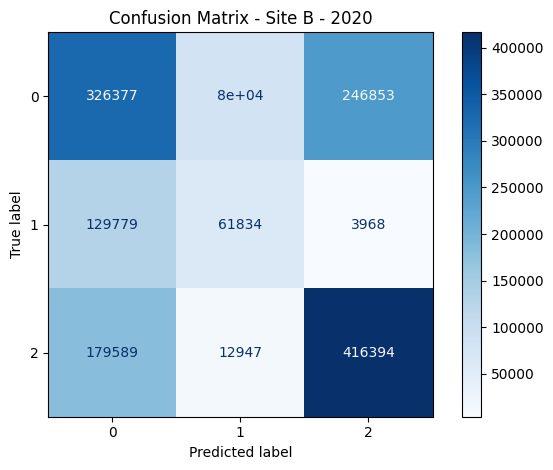

In [24]:
acc, kappa, per_class_f1, avg_f1, cm = evaluate(model, test_dataloader, T, device=DEVICE)

# Printing and plotting
print("Stochastic" + f" Accuracy (mean over T): {acc:.4f}" if (T>1) else "Deterministic" + f" Accuracy (mean over T): {acc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"Per-class F1: {per_class_f1}")
print(f"Average F1 (macro): {avg_f1:.4f}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix - Site {SITE} - {YEAR}")
plt.tight_layout()
plt.show()

## Training Loop

In [25]:
# ===== Class weights =====
all_labels = []
for _, y_batch in train_dataloader:
    all_labels.append(y_batch.numpy())

all_labels = np.concatenate(all_labels)
classes = np.unique(all_labels)
class_weights_np = compute_class_weight(class_weight='balanced',
                                        classes=classes, y=all_labels)
class_weights = torch.tensor(class_weights_np, dtype=torch.float).to(DEVICE)
class_weights = torch.clamp(class_weights, max=1.25) # Clipping to max 1.00
print("Class weights:", class_weights)

Class weights: tensor([0.7438, 1.2500, 0.7980], device='cuda:0')


In [26]:
# ===== Optimizer =====
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [27]:
def ELBO_loss_nll_from_logits(outputs, y_batch, class_weights=None):
    """
    outputs: (T, B, C) or (B, C)
    y_batch: (B,)
    """
    if outputs.dim() == 3:
        T, B, C = outputs.shape
        outputs_flat = outputs.reshape(T * B, C)
        labels_rep = y_batch.unsqueeze(0).expand(T, B).reshape(T * B)
        return F.cross_entropy(outputs_flat, labels_rep,
                               weight=class_weights, reduction='mean')
    else:
        return F.cross_entropy(outputs, y_batch,
                               weight=class_weights, reduction='mean')

In [28]:
# ===== Training Loop =====
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    # === TRAIN ===
    model.train()
    train_loss = 0.0
    train_acc = 0.0

    for x_batch, y_batch in tqdm(train_dataloader, desc=f'Training Epoch {epoch+1}'):
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)

        optimizer.zero_grad()

        # Forward pass with T stochastic samples
        outputs, kl = model(x_batch, sample=True, n_samples=T)  # (T,B,C) + scalar KL

        # Mean NLL across T samples
        nll_mean = ELBO_loss_nll_from_logits(outputs, y_batch, class_weights)
        
        # ELBO Loss
        loss = nll_mean + KL_WEIGHT * kl

        # Backprop
        loss.backward()
        optimizer.step()

        # Stats
        train_loss += loss.item() * x_batch.size(0)
        train_acc += compute_accuracy_per_sample_mean(outputs, y_batch) * x_batch.size(0)

    train_loss /= len(train_dataset)
    train_acc /= len(train_dataset)
    print(f'Loss: {nll_mean:.4f} + {KL_WEIGHT} * {kl}')

    # === VALIDATION ===
    model.eval()
    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad():
        for x_batch, y_batch in tqdm(val_dataloader, desc='Validation'):
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)

            outputs, kl = model(x_batch, sample=False, n_samples=1)  # deterministic eval
            nll = ELBO_loss_nll_from_logits(outputs, y_batch, class_weights)
            loss = nll + KL_WEIGHT * kl

            val_loss += loss.item() * x_batch.size(0)
            val_acc += compute_accuracy_per_sample_mean(outputs, y_batch) * x_batch.size(0)

    val_loss /= len(val_dataset)
    val_acc /= len(val_dataset)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}") 

Training Epoch 1: 100%|██████████| 6075/6075 [02:17<00:00, 44.03it/s]


Loss: 0.5857 + 1e-08 * 2222563.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.85it/s]


Epoch [1/15] Train Loss: 0.2769, Train Acc: 0.9017 | Val Loss: 0.2552, Val Acc: 0.9086


Training Epoch 2: 100%|██████████| 6075/6075 [02:16<00:00, 44.37it/s]


Loss: 0.0071 + 1e-08 * 1908991.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.96it/s]


Epoch [2/15] Train Loss: 0.2401, Train Acc: 0.9131 | Val Loss: 0.2402, Val Acc: 0.9119


Training Epoch 3: 100%|██████████| 6075/6075 [02:17<00:00, 44.34it/s]


Loss: 0.0568 + 1e-08 * 1752727.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.82it/s]


Epoch [3/15] Train Loss: 0.2283, Train Acc: 0.9171 | Val Loss: 0.2329, Val Acc: 0.9144


Training Epoch 4: 100%|██████████| 6075/6075 [02:17<00:00, 44.13it/s]


Loss: 0.2215 + 1e-08 * 1663808.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.20it/s]


Epoch [4/15] Train Loss: 0.2211, Train Acc: 0.9192 | Val Loss: 0.2275, Val Acc: 0.9162


Training Epoch 5: 100%|██████████| 6075/6075 [02:17<00:00, 44.19it/s]


Loss: 0.2791 + 1e-08 * 1611917.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.97it/s]


Epoch [5/15] Train Loss: 0.2154, Train Acc: 0.9213 | Val Loss: 0.2241, Val Acc: 0.9172


Training Epoch 6: 100%|██████████| 6075/6075 [02:17<00:00, 44.24it/s]


Loss: 0.2477 + 1e-08 * 1581112.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.25it/s]


Epoch [6/15] Train Loss: 0.2118, Train Acc: 0.9222 | Val Loss: 0.2242, Val Acc: 0.9169


Training Epoch 7: 100%|██████████| 6075/6075 [02:17<00:00, 44.24it/s]


Loss: 0.6790 + 1e-08 * 1562644.625


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.68it/s]


Epoch [7/15] Train Loss: 0.2074, Train Acc: 0.9237 | Val Loss: 0.2190, Val Acc: 0.9194


Training Epoch 8: 100%|██████████| 6075/6075 [02:17<00:00, 44.13it/s]


Loss: 0.2100 + 1e-08 * 1559238.375


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.49it/s]


Epoch [8/15] Train Loss: 0.2044, Train Acc: 0.9247 | Val Loss: 0.2191, Val Acc: 0.9195


Training Epoch 9: 100%|██████████| 6075/6075 [02:17<00:00, 44.16it/s]


Loss: 0.2564 + 1e-08 * 1560677.375


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.89it/s]


Epoch [9/15] Train Loss: 0.2015, Train Acc: 0.9258 | Val Loss: 0.2269, Val Acc: 0.9176


Training Epoch 10: 100%|██████████| 6075/6075 [02:17<00:00, 44.16it/s]


Loss: 0.0640 + 1e-08 * 1564780.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.19it/s]


Epoch [10/15] Train Loss: 0.1986, Train Acc: 0.9270 | Val Loss: 0.2165, Val Acc: 0.9204


Training Epoch 11: 100%|██████████| 6075/6075 [02:17<00:00, 44.24it/s]


Loss: 0.1358 + 1e-08 * 1578528.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.11it/s]


Epoch [11/15] Train Loss: 0.1962, Train Acc: 0.9280 | Val Loss: 0.2205, Val Acc: 0.9190


Training Epoch 12: 100%|██████████| 6075/6075 [02:17<00:00, 44.15it/s]


Loss: 0.1730 + 1e-08 * 1593378.625


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.44it/s]


Epoch [12/15] Train Loss: 0.1933, Train Acc: 0.9289 | Val Loss: 0.2149, Val Acc: 0.9211


Training Epoch 13: 100%|██████████| 6075/6075 [02:17<00:00, 44.19it/s]


Loss: 0.0379 + 1e-08 * 1612167.625


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.07it/s]


Epoch [13/15] Train Loss: 0.1912, Train Acc: 0.9298 | Val Loss: 0.2195, Val Acc: 0.9201


Training Epoch 14: 100%|██████████| 6075/6075 [02:17<00:00, 44.12it/s]


Loss: 0.3062 + 1e-08 * 1637580.625


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.41it/s]


Epoch [14/15] Train Loss: 0.1887, Train Acc: 0.9308 | Val Loss: 0.2197, Val Acc: 0.9207


Training Epoch 15: 100%|██████████| 6075/6075 [02:18<00:00, 43.72it/s]


Loss: 0.0440 + 1e-08 * 1665447.625


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.39it/s]

Epoch [15/15] Train Loss: 0.1860, Train Acc: 0.9318 | Val Loss: 0.2162, Val Acc: 0.9199


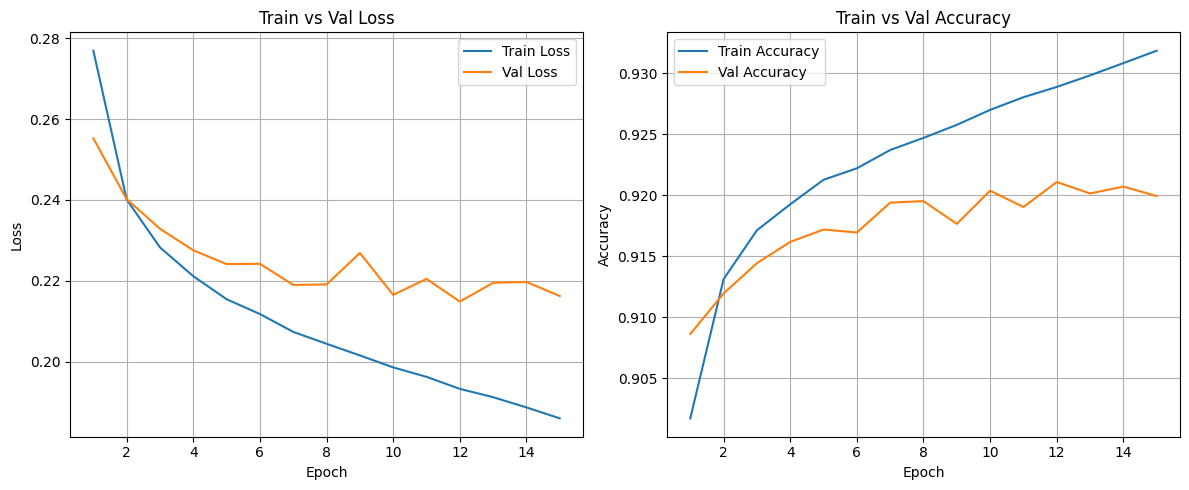

In [29]:
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Val Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label='Train Accuracy')
plt.plot(epochs, val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Val Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Evaluating the Model

Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:40<00:00, 142.03it/s]


Stochastic Accuracy (mean over T): 0.9201
Cohen's Kappa: 0.8685
Per-class F1: [0.92096766 0.92690213 0.91708248]
Average F1 (macro): 0.9217


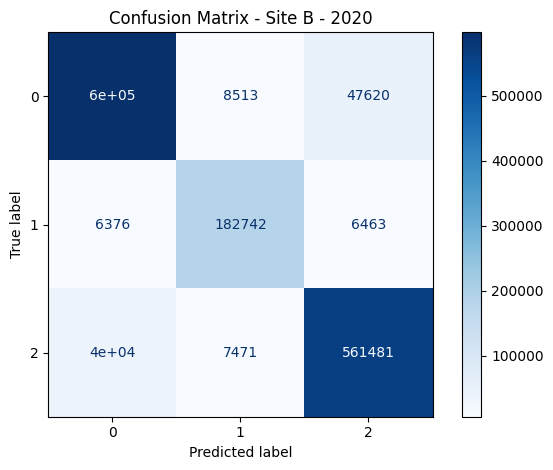

In [30]:
acc, kappa, per_class_f1, avg_f1, cm = evaluate(model, test_dataloader, T, device=DEVICE)

# Printing and plotting
print("Stochastic" + f" Accuracy (mean over T): {acc:.4f}" if (T>1) else "Deterministic" + f" Accuracy (mean over T): {acc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"Per-class F1: {per_class_f1}")
print(f"Average F1 (macro): {avg_f1:.4f}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix - Site {SITE} - {YEAR}")
plt.tight_layout()
plt.show()

<hr>